<h1>
🐝 Projet ML/IA - 'To bee or not to bee'

<h3>1. Imports & Configuration

In [ ]:
# 📦 Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
from collections import Counter
from skimage.io import imread, imsave
from skimage.measure import regionprops, label, moments_hu
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import rotate
from skimage.util import img_as_ubyte
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score, f1_score, recall_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from scipy.ndimage import distance_transform_edt
from scipy.optimize import minimize
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8')

<h3>2. Load data and setup paths

In [ ]:
# 📁 Initializing folder paths and filenames

image_dir = 'train/'
mask_dir = 'train/masks/'
cropped_dir = 'cropped/'
cropped_masks_dir = 'cropped/masks/'
inscribed_circles_dir = 'circles/'
symmetry_axes_dir = 'symmetry_axes/'
test_image_dir = 'test/'  # For images 251-347
test_mask_dir = 'test/masks/'
extracted_features_file = 'extracted_features.csv'

<font color='yellow'><h5> Load data and display basic stats

In [ ]:
# Raw dataset visualization

try:
    label_df = pd.read_excel('classif.xlsx')
    print("Classification file loaded successfully")
    print(f"Number of training samples: {len(label_df)}")
    print("\nBug type distribution:")
    print(label_df['bug type'].value_counts())
    print("\nSpecies distribution:")
    print(label_df['species'].value_counts())
except Exception as e:
    print(f"Error loading classification file: {e}")

Classification file loaded successfully
Number of training samples: 250

Bug type distribution:
bug type
Bee                115
Bumblebee          100
Butterfly           15
Hover fly            9
Wasp                 9
Dragonfly            1
Bee & Bumblebee      1
Name: count, dtype: int64

Species distribution:
species
Bombus hortorum                              71
Apis mellifera                               58
Bombus pascuorum                             25
Anthidium manicatum                          19
Megachile centuncularis                      17
Eristalis                                     9
Vespula germanica                             8
Anthidium                                     6
Macroglossum stellatarum                      5
Andrenidae                                    4
Pieris rapae                                  4
Aglais urticae                                3
Thyreus                                       3
Polyommatus icarus                            2
Bombu

<h3>3. Mask Pre-Processing and Feature Extraction Functions

In [5]:
def preprocess_mask(mask_path, image_path=None, save_id=None):
    """
    Clean mask and crop iamge and mask to the bounding box
    """
    mask = imread(mask_path, as_gray=True) > 0
    labeled = label(mask)
    props = regionprops(labeled)

    if not props:
        return None, None

    largest = max(props, key=lambda x: x.area)
    clean_mask = labeled == largest.label
    minr, minc, maxr, maxc = largest.bbox
    cropped_mask = clean_mask[minr:maxr, minc:maxc]

    if image_path:
        image = imread(image_path)
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        cropped_image = image[minr:maxr, minc:maxc]
    else:
        cropped_image = None
        
    if save_id is not None:
        imsave(f'{cropped_masks_dir}cropped_mask_{save_id}.png', img_as_ubyte(cropped_mask.astype(bool)))
        if cropped_image is not None:
            imsave(f'{cropped_dir}cropped_image_{save_id}.png', img_as_ubyte(cropped_image))

    return cropped_mask, cropped_image

def find_best_inscribed_circle(binary_mask):
    """
    Return x, y and radius of the largest inscribed cricle in the mask.
    """
    if np.sum(binary_mask) == 0:
        return 0, 0, 0  # masque vide

    labeled_mask = label(binary_mask)
    props = regionprops(labeled_mask)

    if not props:
        return 0, 0, 0  # aucune région détectée

    # Choisir la plus grande région connectée
    main_region = max(props, key=lambda p: p.area)
    centroid = np.array(main_region.centroid)

    distance = distance_transform_edt(binary_mask)

    def neg_radius(params):
        x, y = params
        ix, iy = int(x), int(y)
        if 0 <= iy < distance.shape[0] and 0 <= ix < distance.shape[1]:
            return -distance[iy, ix]
        return 1e6  # pénaliser les positions hors du masque

    try:
        result = minimize(neg_radius, x0=centroid[::-1],
                          bounds=[(0, binary_mask.shape[1]), (0, binary_mask.shape[0])])
        if result.success:
            best_x, best_y = result.x
            best_radius = distance[int(best_y), int(best_x)]
            return best_x, best_y, best_radius
        else:
            return 0, 0, 0  # optimisation échouée
    except:
        return 0, 0, 0  # sécurité ultime

def create_circular_mask(shape, center, radius):
    """
    Xreate a mask based on the associated inscribed circle
    """
    h, w = shape
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    return dist_from_center <= radius

def save_inscribed_circle_overlay(image, center_x, center_y, radius, save_path):
    """
    Draw and save inscribed cricle
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image)
    circle = Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def vertical_symmetry_loss(angle, image, xc, yc, mask=None):
    angle = float(angle)  
    rotated = rotate(image, angle, resize=False, center=(xc, yc), preserve_range=True)
    flipped = rotated[:, ::-1, ...]
    difference = (rotated - flipped) ** 2
    if mask is not None:
        mask_rot = rotate(mask.astype(float), angle, resize=False, center=(xc, yc), preserve_range=True)
        return np.mean(difference[mask_rot > 0.5])
    return np.mean(difference)

def find_best_symmetry_angle(image, center_x, center_y, mask=None):
    result = minimize(vertical_symmetry_loss, x0=0, args=(image, center_x, center_y, mask), bounds=[(-45, 45)])
    return result.x[0]

def save_symmetry_axis_overlay(image, center_x, center_y, angle, save_path):
    """
    DIsplay and saves the symmetry axis of the image
    """
    rotated = rotate(image, angle, resize=False, center=(center_x, center_y), preserve_range=True)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(rotated.astype(np.uint8))
    ax.axvline(center_x, color='cyan', linestyle='--', linewidth=2, label="Symmetry Axis")
    ax.set_title(f"Symmetry axis at angle {angle:.2f}°")
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def extract_comprehensive_features(image_path, mask_path, img_id=None):
    """
    Extract images / mask features.
    Project requirements and personnal additions
    """
    try:
        # REQUIRED : Load cropped image and mask
        mask, image = preprocess_mask(mask_path, image_path, img_id)
        if mask is None or image is None:
            return None
        
        # Ensure image is 3D (RGB)
        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=2)
        
        # Get region properties
        labeled_mask = label(mask.astype(int))
        props = regionprops(labeled_mask)
        
        features = {}
        
        # REQUIRED: Inscribed circle
        try:
            cx, cy, radius = find_best_inscribed_circle(mask)
            features['inscribed_circle_radius'] = radius
            circle_path = f'{inscribed_circles_dir}circle_{img_id}.png'
            save_inscribed_circle_overlay(image, cx, cy, radius, circle_path)
        except:
            features['inscribed_circle_radius'] = 0
        """
        # REQUIRED: Vertical symetry
        try:
            symmetry_angle = find_best_symmetry_angle(image, cx, cy, mask)
            features['symmetry_angle'] = symmetry_angle
            symmetry_path = f'{symmetry_axes_dir}symmetry_{img_id}.png'
            save_symmetry_axis_overlay(image, cx, cy, symmetry_angle, symmetry_path)
        except Exception as e:
            print(f"[ERROR] Failed to compute symmetry for ID {img_id}: {e}")
            features['symmetry_angle'] = 0
        """
        # REQUIRED: Area ratio (pixels of bug / pixels of full image)
        total_pixels = mask.shape[0] * mask.shape[1]
        bug_pixels = np.sum(mask)
        features['area_ratio'] = bug_pixels / total_pixels
        
        # REQUIRED: RGB statistics within bug mask
        for i, color in enumerate(['R', 'G', 'B']):
            if image.shape[2] > i:
                channel = image[:, :, i]
                values = channel[mask]
                if len(values) > 0:
                    features[f'{color}_min'] = np.min(values)
                    features[f'{color}_max'] = np.max(values)
                    features[f'{color}_mean'] = np.mean(values)
                    features[f'{color}_median'] = np.median(values)
                    features[f'{color}_std'] = np.std(values)
                else:
                    # Handle empty mask case
                    for stat in ['min', 'max', 'mean', 'median', 'std']:
                        features[f'{color}_{stat}'] = 0
                        
        # ADDITIONAL: RGB statistics within inscibed circle mask
        circle_mask = create_circular_mask(mask.shape, (cx, cy), radius)
        for i, (color, stat) in enumerate([('R', 'mean'),('G', 'std'),('B', 'median')]):
            if image.shape[2] > i:
                channel = image[:, :, i]
                values = channel[circle_mask]
                if len(values):
                    if stat == 'mean':
                        features[f'circle_{color}_{stat}'] = np.mean(values)
                    elif stat == 'std':
                        features[f'circle_{color}_{stat}'] = np.std(values)
                    elif stat == 'median':
                        features[f'circle_{color}_{stat}'] = np.median(values)
                else:
                    features[f'circle_{color}_{stat}'] = 0
            
        # ADDITIONAL: Shape and symmetry measures features
        if props:
            prop = props[0]  # Take the largest connected component

            features['aspect_ratio'] = prop.major_axis_length / max(prop.minor_axis_length, 1e-6)
            features['eccentricity'] = prop.eccentricity
            features['compactness'] = (prop.perimeter ** 2) / max(prop.area, 1e-6)
            features['roundness'] = (4 * np.pi * prop.area) / max(prop.perimeter ** 2, 1e-6)
            features['orientation'] = prop.orientation
            features['solidity'] = prop.solidity
            
        else:
            # Default values if no region found
            shape_features = ['eccentricity', 'solidity', 'aspect_ratio', 'compactness', 'roundness', 'orientation']
            for feat in shape_features:
                features[feat] = 0
                
        # ADDITIONAL: Other features
        # Edge Density
        try:
            gray_image = np.mean(image, axis=2).astype(np.uint8)
            edges = sobel(gray_image)
            features['edge_density'] = np.sum(edges[mask]) / max(np.sum(mask), 1)
        except:
            features['edge_density'] = 0

        # Texture (GLCM)
        try:
            gray_image = np.mean(image, axis=2).astype(np.uint8)
            region = gray_image * mask
            region_quant = (region / 255 * 32).astype(np.uint8)
            glcm = graycomatrix(region_quant, [1], [0], levels=32, symmetric=True, normed=True)
            features['glcm_homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
            features['glcm_energy'] = graycoprops(glcm, 'energy')[0, 0]
        except:
            for feat in ['homogeneity', 'energy']:
                features[f'glcm_{feat}'] = 0
       
        # Body wings ratio
        try:
            mask_area = np.sum(mask)  # zone du bug
            circle_area = np.pi * (features['inscribed_circle_radius'] ** 2)
            if circle_area > 0:
                features['wings_body_ratio'] = (mask_area - circle_area) / circle_area
            else:
                features['wings_body_ratio'] = 0 
        except:
            features['wings_body_ratio'] = 0
        
        # Intensity on central axe (stripe detection ?)
        try:
            strip_width = 5
            x_start = int(max(0, cx - strip_width))
            x_end = int(min(image.shape[1], cx + strip_width))

            central_strip = image[:, x_start:x_end, :]  

            if central_strip.size > 0 and x_end > x_start:
                central_std = np.std(central_strip, axis=(0, 1))
                features['central_rgb_variation'] = np.mean(central_std)
            else:
                features['central_rgb_variation'] = 0  # fallback
        except:
            features['central_rgb_variation'] = 0
        
        return features
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

<h3>4. Extract features from training set</h3>

<font color='yellow'><h5>a) Extracting process

In [ ]:
print("Extracting features from training images...")
feature_list = []
failed_extractions = []

# If feature sets already exists in a csv file, load them instead of extracting from scratch
if os.path.exists(extracted_features_file):
    print(f"Loading existing features from {extracted_features_file}")
    feature_list = pd.read_csv(extracted_features_file).to_dict(orient='records')

else:
    print("No existing features found, extracting from scratch.")
    for i, row in label_df.iterrows():
        img_id = row['ID']
        img_path = os.path.join(image_dir, f"{img_id}.JPG")
        mask_path = os.path.join(mask_dir, f"binary_{img_id}.tif")
        
        # We make sure to check if image and mask exist for each ID
        try:
            if not os.path.exists(img_path):
                print(f"[WARNING] Image missing: {img_path}")
                failed_extractions.append(img_id)
                continue
            if not os.path.exists(mask_path):
                print(f"[WARNING] Mask missing: {mask_path}")
                failed_extractions.append(img_id)
                continue
            
            features = extract_comprehensive_features(img_path, mask_path, img_id)
            if features is not None:
                features['ID'] = img_id
                features['bug_type'] = row['bug type']
                features['species'] = row['species']
                feature_list.append(features)
            else:
                failed_extractions.append(img_id)
                
        except Exception as e:
            print(f"[ERROR] Problem with ID {img_id}: {e}")
            failed_extractions.append(img_id)

Extracting features from training images...
Loading existing features from extracted_features.csv


<font color='yellow'><h5>b) Storing extracted features into a pandas dataframe and extracting into csv format

In [105]:
df_features = pd.DataFrame(feature_list)
print(f"\nFeature extraction completed!")
print(f"Successfully processed: {len(df_features)} images")
print(f"Failed extractions: {len(failed_extractions)} images")
print(f"Feature dimensions: {df_features.shape}")

# Display basic statistics
print("\n=== FEATURE SUMMARY ===")

feature_cols = [col for col in df_features.columns if col not in ['ID', 'bug_type', 'species']]

print(f"Total features extracted: {len(feature_cols)}")
print("\nFeature list:")
for i, feat in enumerate(feature_cols, 1):
    print(f"{i:2d}. {feat}")

# Save features to CSV 
df_features.to_csv('extracted_features.csv', index=False)
print("\nFeatures saved to 'extracted_features.csv'")

print("\n=== SAMPLE DATA ===")
print(df_features.head())


Feature extraction completed!
Successfully processed: 249 images
Failed extractions: 0 images
Feature dimensions: (249, 34)

=== FEATURE SUMMARY ===
Total features extracted: 31

Feature list:
 1. inscribed_circle_radius
 2. area_ratio
 3. R_min
 4. R_max
 5. R_mean
 6. R_median
 7. R_std
 8. G_min
 9. G_max
10. G_mean
11. G_median
12. G_std
13. B_min
14. B_max
15. B_mean
16. B_median
17. B_std
18. circle_R_mean
19. circle_G_std
20. circle_B_median
21. aspect_ratio
22. eccentricity
23. compactness
24. roundness
25. orientation
26. solidity
27. edge_density
28. glcm_homogeneity
29. glcm_energy
30. wings_body_ratio
31. central_rgb_variation

Features saved to 'extracted_features.csv'

=== SAMPLE DATA ===
   inscribed_circle_radius  area_ratio  R_min  R_max      R_mean  R_median  \
0               128.128841    0.506544      5    208   68.047510      56.0   
1               109.658561    0.431831      2    248   63.721829      55.0   
2               179.175891    0.448143      3    255 

<h3>5. Dataset visualization and preparation

<font color='yellow'><h5> a) Bugs and species distribution

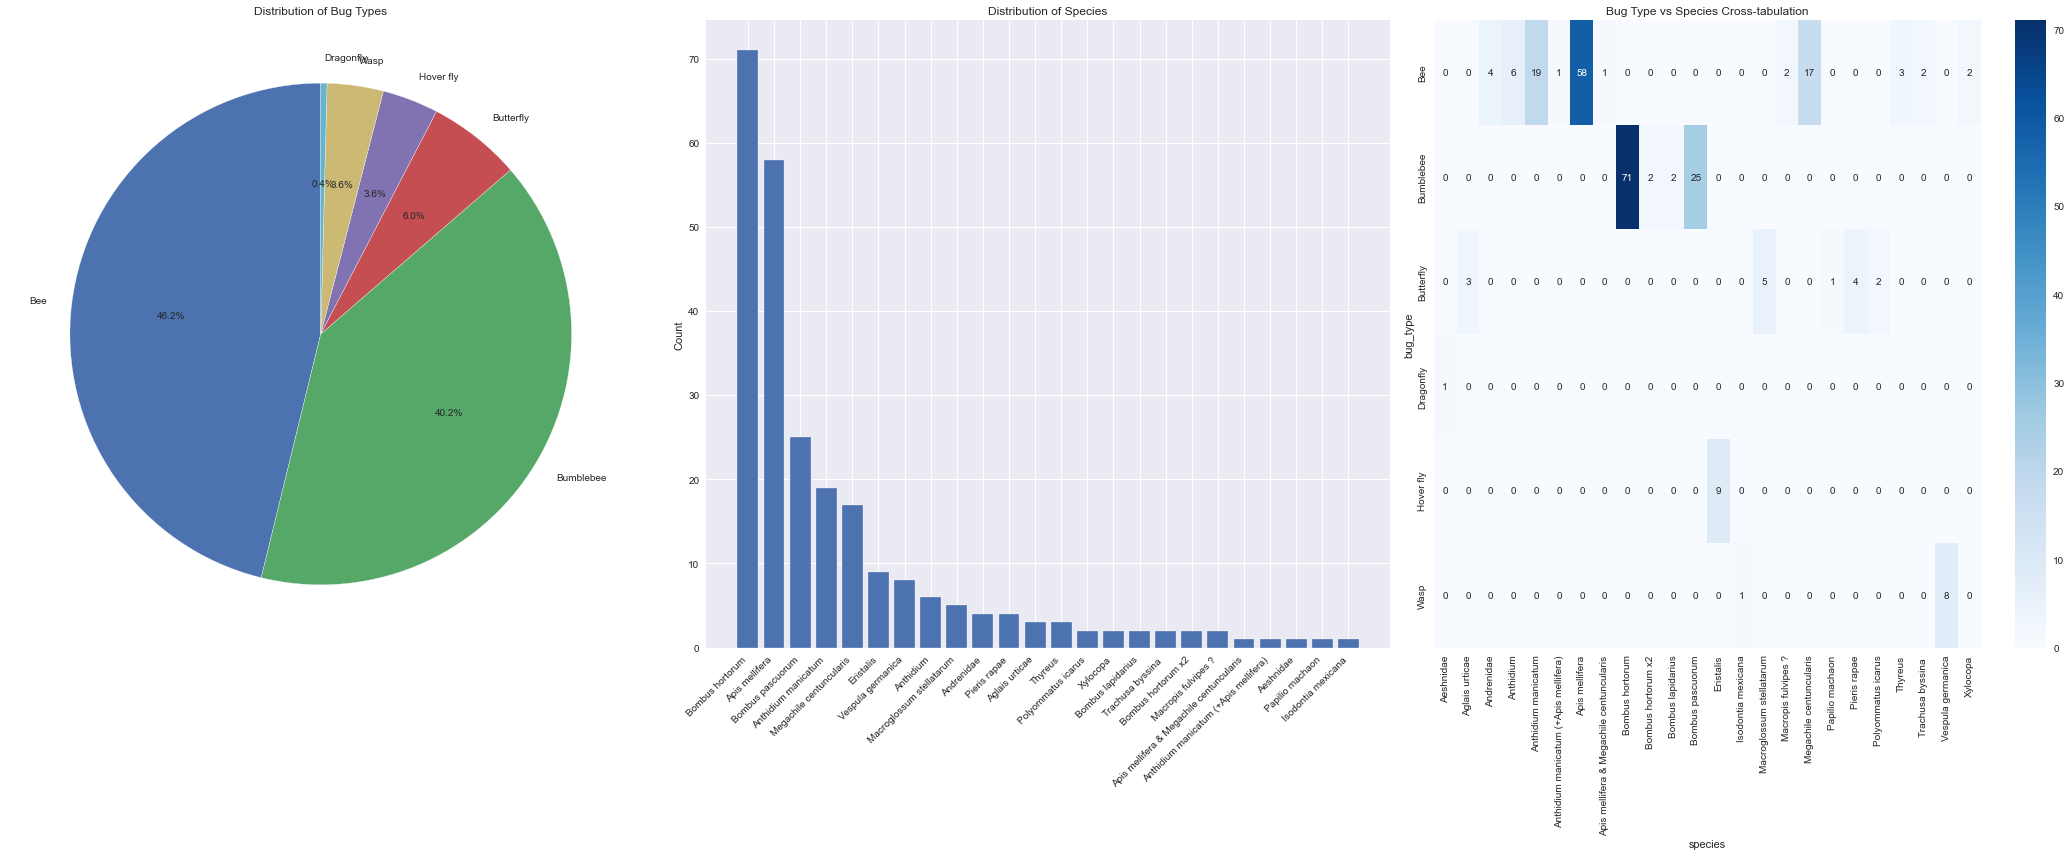

In [ ]:
# Plotting data distributions
plt.figure(figsize=(30, 12))

plt.subplot(1, 3, 1)
bug_counts = df_features['bug_type'].value_counts()
plt.pie(bug_counts.values, labels=bug_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Bug Types')

plt.subplot(1, 3, 2)
species_counts = df_features['species'].value_counts()
plt.bar(range(len(species_counts)), species_counts.values)
plt.xticks(range(len(species_counts)), species_counts.index, rotation=45, ha='right')
plt.title('Distribution of Species')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
# Cross-tabulation
ct = pd.crosstab(df_features['bug_type'], df_features['species'])
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title('Bug Type vs Species Cross-tabulation')

plt.tight_layout()
plt.show()

<font color='yellow'><h5> b) Bugs type reduction

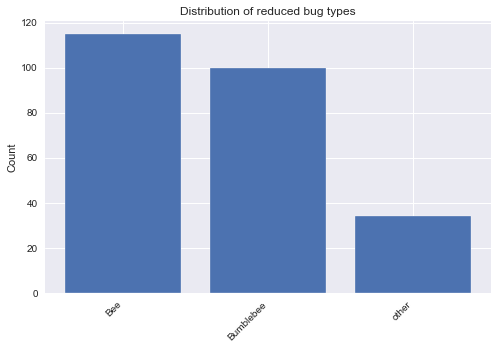

In [ ]:
# We will also work with a subset of bug types grouping every small classes 
df_features["reduced_bug_type"] = df_features["bug_type"].apply(lambda x: x if x in ["Bee", "Bumblebee"] else "other")

plt.figure(figsize=(8, 5))
species_counts = df_features['reduced_bug_type'].value_counts()
plt.bar(range(len(species_counts)), species_counts.values)
plt.xticks(range(len(species_counts)), species_counts.index, rotation=45, ha='right')
plt.title('Distribution of reduced bug types')
plt.ylabel('Count')

plt.show()

<font color='yellow'><h5>c) Features visualization

In [102]:
# Load the features that were previously extracted
df = df_features.copy()   # Copy to avoid modifying the original DataFrame

# Show all available columns (features + metadata)
print("All features in the dataset:")
print(df.columns.tolist())

# Keep only feature columns (remove ID and labels)
X = df[feature_cols]

All features in the dataset:
['inscribed_circle_radius', 'area_ratio', 'R_min', 'R_max', 'R_mean', 'R_median', 'R_std', 'G_min', 'G_max', 'G_mean', 'G_median', 'G_std', 'B_min', 'B_max', 'B_mean', 'B_median', 'B_std', 'circle_R_mean', 'circle_G_std', 'circle_B_median', 'aspect_ratio', 'eccentricity', 'compactness', 'roundness', 'orientation', 'solidity', 'edge_density', 'glcm_homogeneity', 'glcm_energy', 'wings_body_ratio', 'central_rgb_variation', 'ID', 'bug_type', 'species', 'reduced_bug_type']


In [100]:
# Checking features that could have bad values
# possible NaN values :
nan_rows = df[df['central_rgb_variation'].isna()]
print("Images avec NaN dans 'central_rgb_variation':")
print(nan_rows[['ID', 'central_rgb_variation']])

# possible inf values :
inf_rows = df[np.isinf(df['wings_body_ratio'])]
print("\nImages avec Inf dans 'wings_body_ratio':")
print(inf_rows[['ID', 'wings_body_ratio']])


Images avec NaN dans 'central_rgb_variation':
Empty DataFrame
Columns: [ID, central_rgb_variation]
Index: []

Images avec Inf dans 'wings_body_ratio':
Empty DataFrame
Columns: [ID, wings_body_ratio]
Index: []


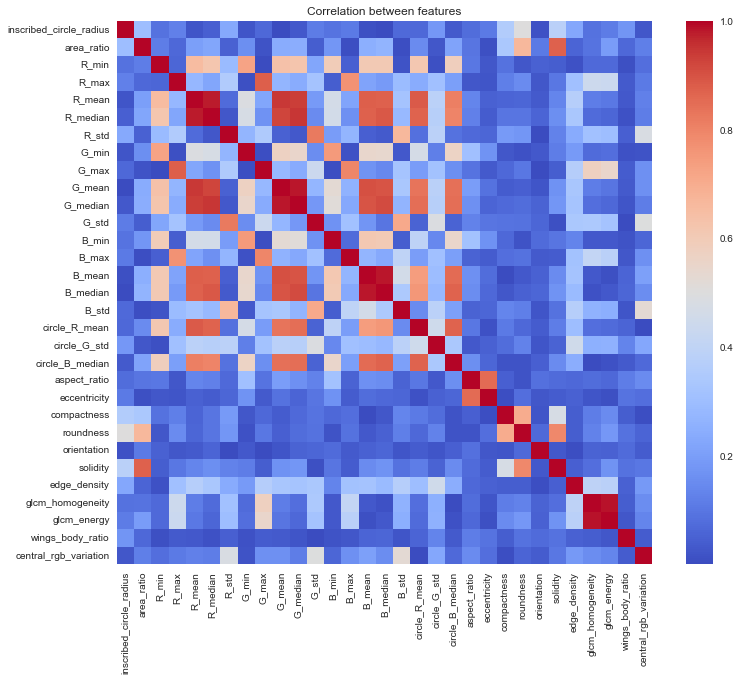

In [94]:
# Calculate absolute correlation between features
corr_matrix = X.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation between features")
plt.show()


<font color='yellow'><h5>d) Filtering features with high correlation

In [99]:
# Drop one of each pair of features with correlation > 0.95
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

print(f"\nHighly correlated features (to be removed): {to_drop}")

# Manually selecting the features from the detected pairs (and more) 
to_drop_manual = ['glcm_homogeneity', 'R_max', 'G_max', 'B_max', 'R_std', 'G_std', 'B_std']


Highly correlated features (to be removed): []


In [103]:
# Drop them
X_filtered = X.drop(columns=to_drop_manual)  

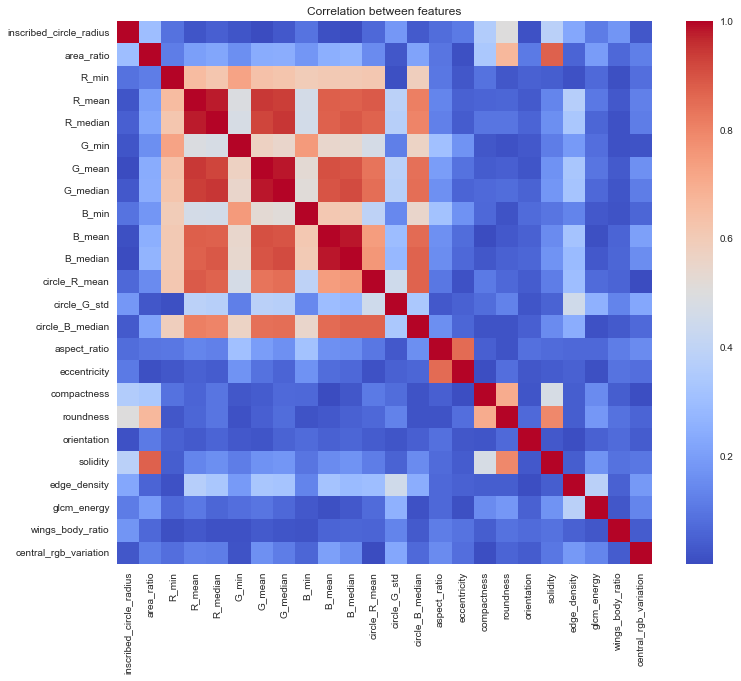

In [104]:
# Combine with labels again for further training
# We are creating a sub dataset so we can work with every versions and compare performances
df_cleaned = pd.concat([df[['ID', 'bug_type', 'species', 'reduced_bug_type']], X_filtered], axis=1)
optimized_feature_cols = X_filtered.columns.tolist()

filtered_X = df_cleaned[optimized_feature_cols]

# Compute new correlation matrice
corr_matrix = filtered_X.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation between features")
plt.show()

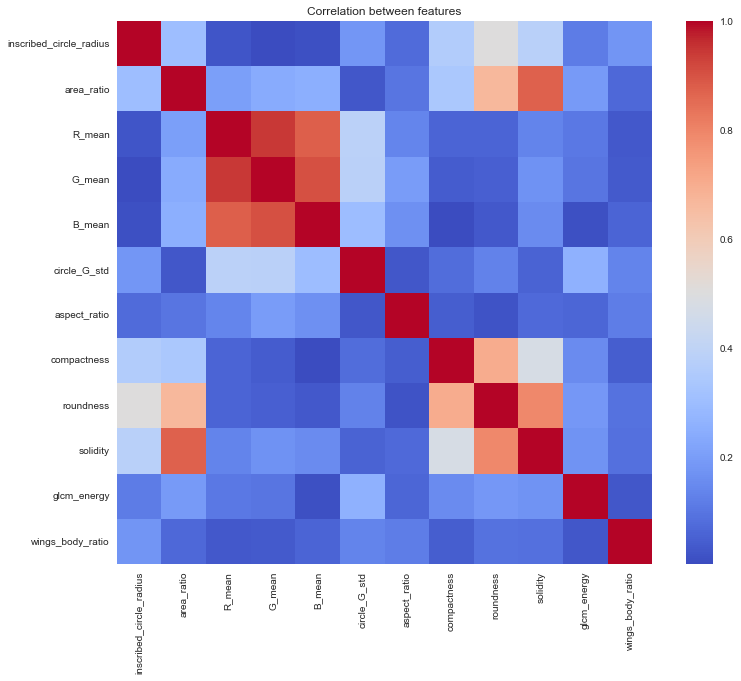

In [ ]:
# DEEPER FEATURE FILTERING

X_filtered_2 = X_filtered.drop(columns=['R_median', 'G_median', 'B_median', 'R_min', 'G_min', 'B_min', 'central_rgb_variation', 'circle_R_mean', 'circle_B_median', 'orientation', 'edge_density','eccentricity'])

df_cleaned_2 = pd.concat([df[['ID', 'bug_type', 'species']], X_filtered_2], axis=1)
optimized_feature_cols_2 = X_filtered_2.columns.tolist()

filtered_X = df_cleaned_2[optimized_feature_cols_2]
corr_matrix = filtered_X.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation between features")
plt.show()


<font color='yellow'><h5>d) comparing full sets performances with basic RF

In [115]:
# Running RF on both feature sets for both class targets

y = df['bug_type']
y2 = df['reduced_bug_type']

sets = [X, X_filtered]
targets = [y, y2]

results = {}

for i, (X_set, y_set) in enumerate([(s, t) for s in sets for t in targets]):
    print(f"\n=== Running Random Forest on Feature Set {i+1} ===")
    print(f"Feature set shape: {X_set.shape[1]} features")
    print(f"Target classes {y_set.name}")
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_set)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_set, test_size=0.2, random_state=42)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    
    # Evaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Feature importance from Random Forest
    feature_importance_rf = rf.feature_importances_
    top_features_rf_idx = np.argsort(feature_importance_rf)[-40:]
    top_features_rf = [X_set.columns.tolist()[i] for i in top_features_rf_idx]
    
    # Storing RF results for plots
    results[f'feature_set_{i+1}'] = (y_test, y_pred, feature_importance_rf, top_features_rf, top_features_rf_idx)



=== Running Random Forest on Feature Set 1 ===
Feature set shape: 31 features
Target classes bug_type
Accuracy: 0.7
Balanced Accuracy: 0.39333333333333337
              precision    recall  f1-score   support

         Bee       0.75      0.80      0.77        30
   Bumblebee       0.59      0.67      0.62        15
   Butterfly       1.00      0.50      0.67         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.70        50
   macro avg       0.47      0.39      0.41        50
weighted avg       0.67      0.70      0.68        50


=== Running Random Forest on Feature Set 2 ===
Feature set shape: 31 features
Target classes reduced_bug_type
Accuracy: 0.66
Balanced Accuracy: 0.5333333333333333
              precision    recall  f1-score   support

         Bee       0.73      0.73      0.73        30
   Bumblebee       0.56      0.67      0.61        15
       other       0.50     


=== Confusion Matrices ===


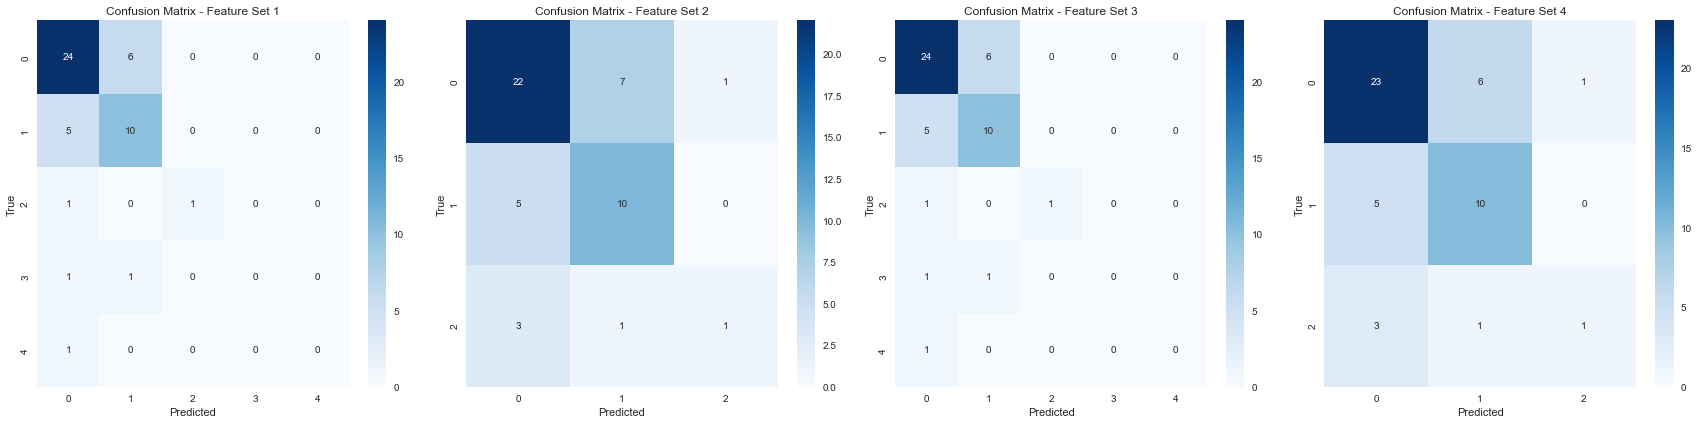


=== Feature Importances ===


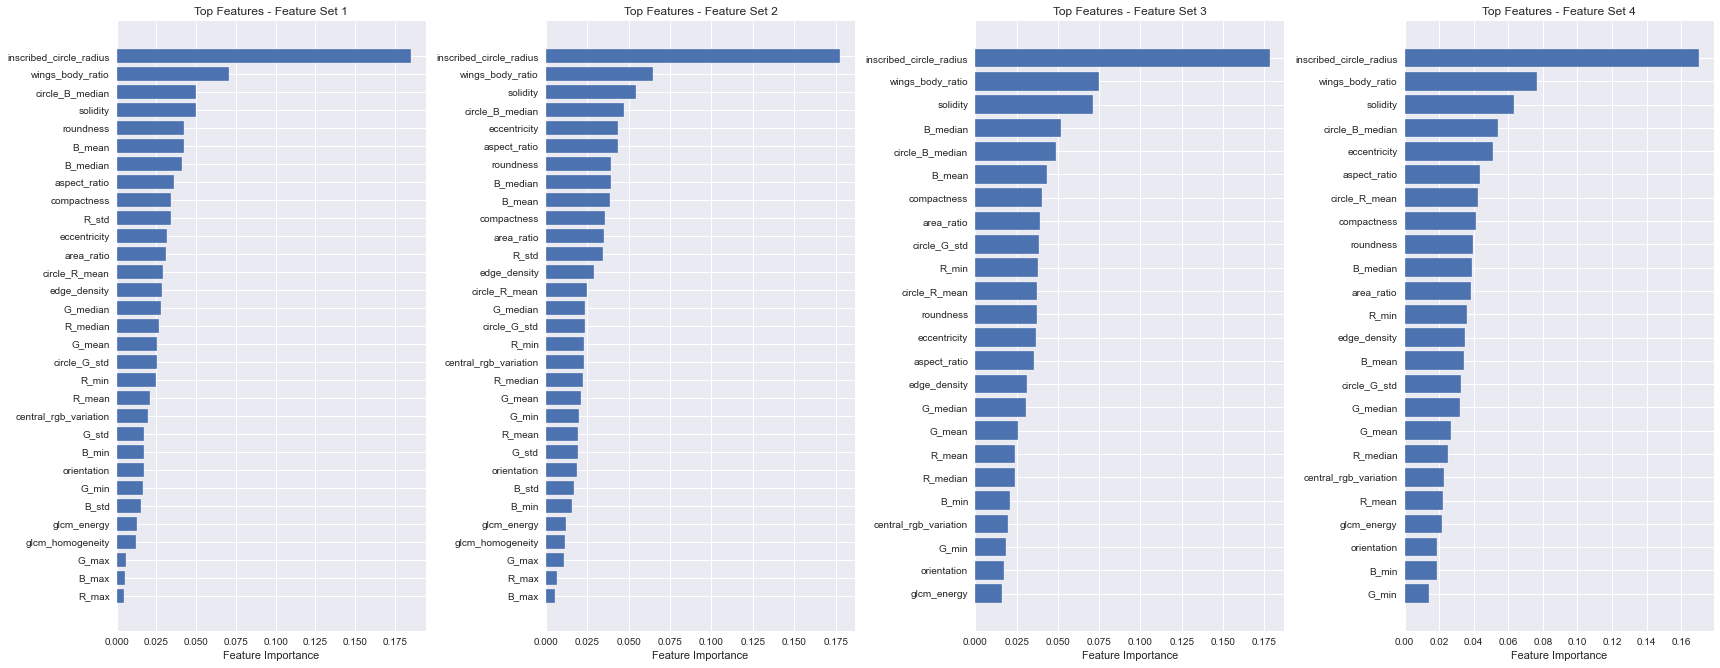

In [120]:
# Plotting confusion matrices
print("\n=== Confusion Matrices ===")
plt.figure(figsize=(24, 6))
for i, (y_test, y_pred, feature_importance_rf, top_features_rf, top_features_rf_idx) in enumerate(results.values()):
    
    plt.subplot(1, len(results), i + 1)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Feature Set {i + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
plt.tight_layout()
plt.show()

# Plotting feature importance
print("\n=== Feature Importances ===")
plt.figure(figsize=(24, 18))
for i, (y_test, y_pred, feature_importance_rf, top_features_rf, top_features_rf_idx) in enumerate(results.values()):
    
    plt.subplot(2, len(results), i + 1)
    plt.barh(range(len(top_features_rf)), feature_importance_rf[top_features_rf_idx])
    plt.yticks(range(len(top_features_rf)), top_features_rf)
    plt.xlabel('Feature Importance')
    plt.title(f'Top Features - Feature Set {i + 1}')
    
plt.tight_layout()
plt.show()


<h5>5.2 PCA Projection 

In [42]:
# Prepare data for full features set
X = df_features[feature_cols].fillna(0)
y_bug_type = df_features['bug_type']
y_species = df_features['species']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare data for reduced features set
X_reduced = df_cleaned_2[optimized_feature_cols_2].fillna(0)
X_reduced_scaled = scaler.fit_transform(X_reduced)


=== PCA ANALYSIS ===
PCA Variance explained by first 2 components: [0.29304306 0.24587267]
Total variance explained: 0.539


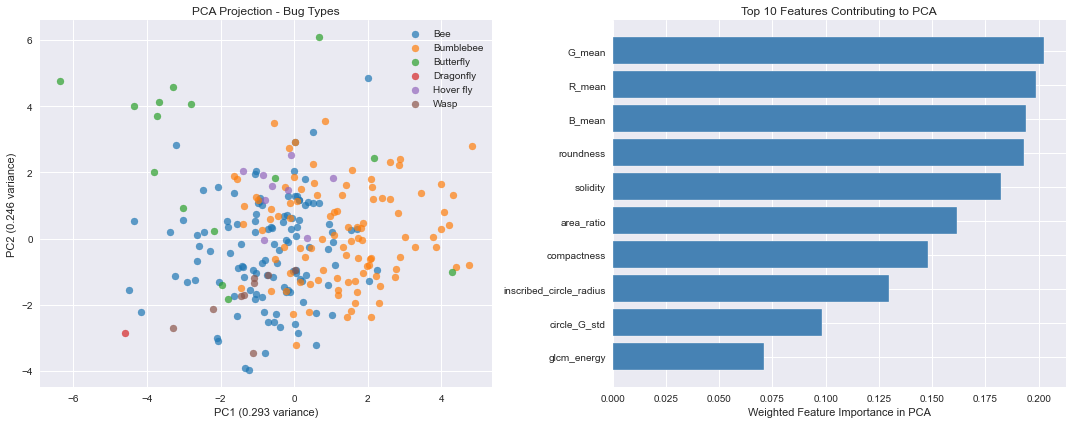

In [43]:
print("\n=== PCA ANALYSIS ===")

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_reduced_scaled)

print(f"PCA Variance explained by first 2 components: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")

# Plot PCA results

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

classes = sorted(y_bug_type.unique())  
colors = plt.cm.tab10.colors

for i, cls in enumerate(classes):
    mask = (y_bug_type == cls)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=cls, color=colors[i % len(colors)], alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
plt.title('PCA Projection - Bug Types')

# Add legend

plt.legend()
plt.subplot(1, 2, 2)

weighted_importance = np.sum(
    np.abs(pca.components_) * pca.explained_variance_ratio_[:, np.newaxis],
    axis=0
)

# Sélection des top 10 features
top_features_idx = np.argsort(weighted_importance)[-10:][::-1]
top_features = [optimized_feature_cols_2[i] for i in top_features_idx]
top_importance = weighted_importance[top_features_idx]

plt.barh(range(len(top_features))[::-1], top_importance, color='steelblue')
plt.yticks(range(len(top_features))[::-1], top_features)
plt.xlabel('Weighted Feature Importance in PCA')
plt.title('Top 10 Features Contributing to PCA')

plt.tight_layout()
plt.show()

<h5>5.3 Non-linear projections 


=== NON-LINEAR PROJECTIONS ===
Computing t-SNE projection...
UMAP not available, using Isomap instead...


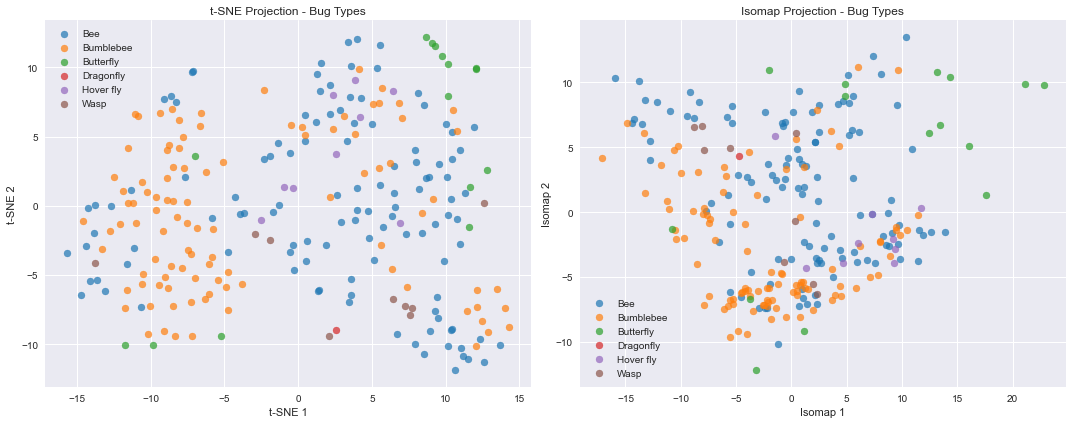

In [14]:
print("\n=== NON-LINEAR PROJECTIONS ===")

# t-SNE projection
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)-1))
X_tsne = tsne.fit_transform(X_scaled)

# UMAP projection (if available, otherwise use another method)
try:
    from umap import UMAP
    print("Computing UMAP projection...")
    umap_reducer = UMAP(n_components=2, random_state=42)
    X_umap = umap_reducer.fit_transform(X_scaled)
    has_umap = True
except ImportError:
    print("UMAP not available, using Isomap instead...")
    from sklearn.manifold import Isomap
    isomap = Isomap(n_components=2)
    X_umap = isomap.fit_transform(X_scaled)
    has_umap = False

# Plot non-linear projections
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

for i, cls in enumerate(classes):
    mask = (y_bug_type == cls)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=cls, color=colors[i % len(colors)], alpha=0.7)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Projection - Bug Types')
plt.legend()

plt.subplot(1, 2, 2)

for i, cls in enumerate(classes):
    mask = (y_bug_type == cls)
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=cls, color=colors[i % len(colors)], alpha=0.7)
    
plt.xlabel('UMAP 1' if has_umap else 'Isomap 1')
plt.ylabel('UMAP 2' if has_umap else 'Isomap 2')
plt.title(f'{"UMAP" if has_umap else "Isomap"} Projection - Bug Types')
plt.legend()

plt.tight_layout()
plt.show()

<h3>6. Machine Learning Algorithms

<h5>Data preparation

In [111]:
X_ml = df_features[feature_cols].fillna(0)

In [15]:
X_ml = df_cleaned[optimized_feature_cols].fillna(0)

In [44]:
X_ml = df_cleaned_2[optimized_feature_cols_2].fillna(0)

In [45]:
# Prepare data
y_ml = df_cleaned['bug_type']

# Encodage des labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_ml)

# DataFrame complet avec les labels encodés
df_full = X_ml.copy()
df_full['label'] = y_encoded

# Détection des classes rares (1 seul échantillon)
class_counts = df_full['label'].value_counts()
rare_classes = class_counts[class_counts == 1].index.tolist()

# Séparation des rares et du reste
rare_instances = df_full[df_full['label'].isin(rare_classes)]
df_remaining = df_full[~df_full['label'].isin(rare_classes)]

# Split du reste des données
X_remain = df_remaining.drop(columns='label')
y_remain = df_remaining['label']

X_train, X_test, y_train, y_test = train_test_split(
    X_remain,
    y_remain,
    test_size=0.2,
    random_state=42,
    stratify=y_remain if y_remain.value_counts().min() > 1 else None  # stratify si possible
)

# Ajout des classes rares au training
X_train = pd.concat([X_train, rare_instances.drop(columns='label')])
y_train = pd.concat([y_train, rare_instances['label']])

# Standardisation
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)
X_test_scaled = scaler_ml.transform(X_test)

print(f"Nombre de classes rares forcées dans le train: {len(rare_classes)}")
print(f"Répartition y_train: {pd.Series(y_train).value_counts()}")

Nombre de classes rares forcées dans le train: 1
Répartition y_train: label
0    92
1    80
2    12
4     7
5     7
3     1
Name: count, dtype: int64


<h5>6.1 Supervised Methods</h5>
<h7>Method 1: Support Vector Machine

In [106]:
print("\n--- SVM Classifier ---")
svm_clf = SVC(random_state=42, class_weight='balanced', C=1.0, kernel='rbf', gamma='scale', probability=True)
svm_clf.fit(X_train_scaled, y_train)
svm_pred = svm_clf.predict(X_test_scaled)

print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, svm_pred))


--- SVM Classifier ---
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.57      0.67        23
           1       0.76      0.65      0.70        20
           2       0.67      0.67      0.67         3
           4       0.18      1.00      0.31         2
           5       0.67      1.00      0.80         2

    accuracy                           0.64        50
   macro avg       0.62      0.78      0.63        50
weighted avg       0.75      0.64      0.67        50

SVM Confusion Matrix:
[[13  4  1  4  1]
 [ 3 13  0  4  0]
 [ 0  0  2  1  0]
 [ 0  0  0  2  0]
 [ 0  0  0  0  2]]


<h7>Method 2: K-Nearest Neighbors

In [47]:
print("\n--- KNN Classifier ---")
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_scaled, y_train)
knn_pred = knn_clf.predict(X_test_scaled)

print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, knn_pred))


--- KNN Classifier ---
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        23
           1       0.65      0.75      0.70        20
           2       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2

    accuracy                           0.68        50
   macro avg       0.28      0.32      0.30        50
weighted avg       0.61      0.68      0.64        50

KNN Confusion Matrix:
[[19  4  0  0  0]
 [ 3 15  0  2  0]
 [ 1  2  0  0  0]
 [ 0  2  0  0  0]
 [ 2  0  0  0  0]]


<h7>Method 3: Logistic regression

In [48]:
print("\n--- Logistic Regression ---")
lr_clf = LogisticRegression(random_state=42, max_iter=500, C=10, class_weight='balanced', penalty='l2', solver='saga')
# {'C': 10, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l2', 'solver': 'saga'}
lr_clf.fit(X_train_scaled, y_train)
lr_pred = lr_clf.predict(X_test_scaled)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, lr_pred))


--- Logistic Regression ---
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        23
           1       0.65      0.65      0.65        20
           2       0.00      0.00      0.00         3
           4       0.11      0.50      0.18         2
           5       0.00      0.00      0.00         2

    accuracy                           0.58        50
   macro avg       0.30      0.36      0.31        50
weighted avg       0.61      0.58      0.59        50

Logistic Regression Confusion Matrix:
[[15  5  1  2  0]
 [ 3 13  0  4  0]
 [ 0  1  0  2  0]
 [ 0  1  0  1  0]
 [ 2  0  0  0  0]]


<h7>NLP classifier

In [54]:
print("\n--- MLP Classifier ---")
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_clf.fit(X_train_scaled, y_train)
mlp_pred = mlp_clf.predict(X_test_scaled)

print("MLP Classification Report:")
print(classification_report(y_test, mlp_pred))
print("MLP Confusion Matrix:")
print(confusion_matrix(y_test, mlp_pred))


--- MLP Classifier ---
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        23
           1       0.65      0.75      0.70        20
           2       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2

    accuracy                           0.64        50
   macro avg       0.27      0.30      0.28        50
weighted avg       0.57      0.64      0.60        50

MLP Confusion Matrix:
[[17  5  0  1  0]
 [ 5 15  0  0  0]
 [ 1  1  0  1  0]
 [ 0  2  0  0  0]
 [ 2  0  0  0  0]]


<h5>6.2 Ensemble Learning Method 

<h7> Random forest


--- Random Forest Classifier (Ensemble) ---
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78        23
           1       0.67      0.80      0.73        20
           2       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2

    accuracy                           0.70        50
   macro avg       0.28      0.33      0.30        50
weighted avg       0.60      0.70      0.65        50

Random Forest Confusion Matrix:
[[19  4  0  0  0]
 [ 4 16  0  0  0]
 [ 1  2  0  0  0]
 [ 0  2  0  0  0]
 [ 2  0  0  0  0]]


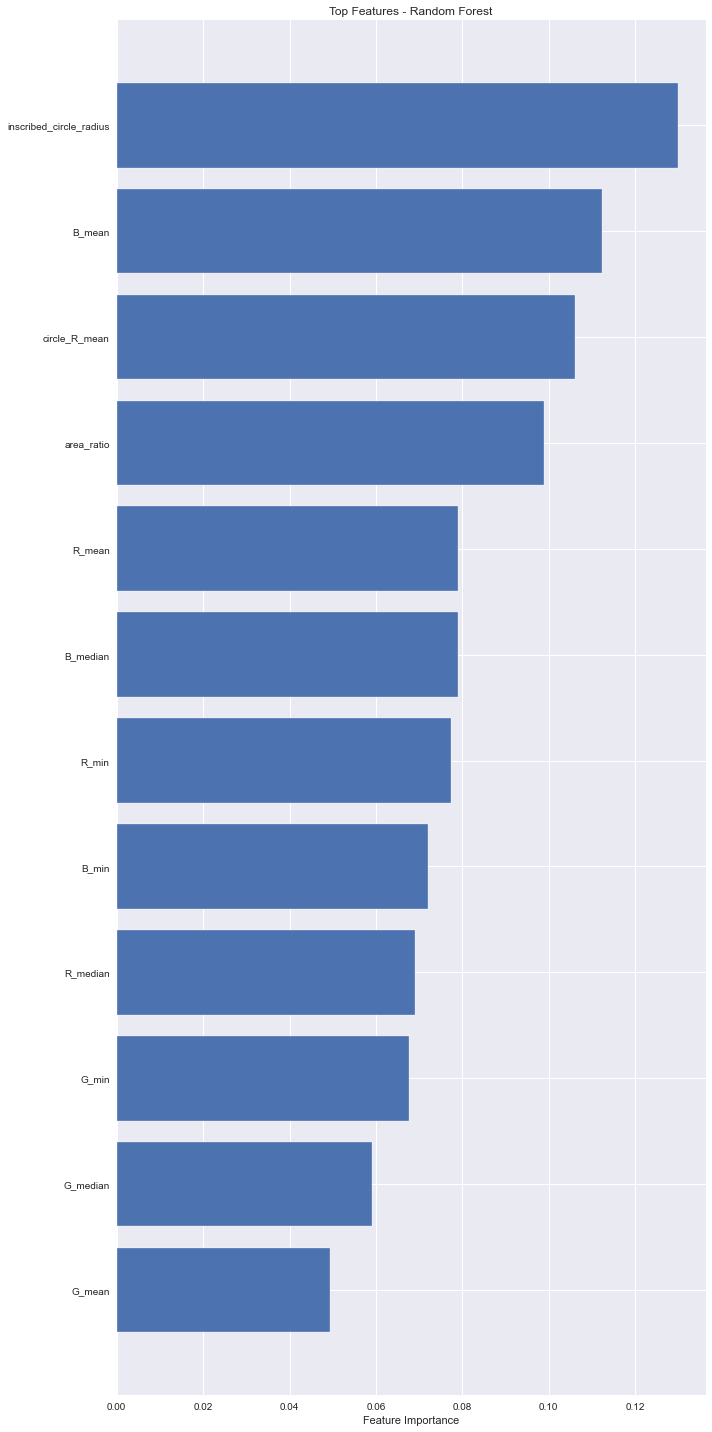

In [ ]:
print("\n--- Random Forest Classifier (Ensemble) ---")
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)  #  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

rf_pred = rf_clf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))



<h7> XGBoost

In [58]:
print("\n--- XGBoost Classifier ---")
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train_scaled, y_train)
xgb_pred = xgb_clf.predict(X_test_scaled)

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred))


--- XGBoost Classifier ---
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75        23
           1       0.67      0.80      0.73        20
           2       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2

    accuracy                           0.68        50
   macro avg       0.28      0.32      0.30        50
weighted avg       0.60      0.68      0.64        50

XGBoost Confusion Matrix:
[[18  5  0  0  0]
 [ 4 16  0  0  0]
 [ 1  1  0  1  0]
 [ 0  2  0  0  0]
 [ 2  0  0  0  0]]


<h7> Voting classifier

In [60]:
print("\n--- Voting Classifier (Ensemble) ---")
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('svc', svm_clf),
        ('mlp', mlp_clf)
    ],
    voting='soft',  # 'hard' for main classes, 'soft' for probabilities
    weights=[1, 1, 3]  # Equal weights for simplicity
)

voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)

print("Voting Classification Report:")
print(classification_report(y_test, voting_pred))
print("Voting Confusion Matrix:")
print(confusion_matrix(y_test, voting_pred))


--- Voting Classifier (Ensemble) ---
Voting Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        23
           1       0.68      0.75      0.71        20
           2       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2

    accuracy                           0.68        50
   macro avg       0.28      0.32      0.29        50
weighted avg       0.60      0.68      0.64        50

Voting Confusion Matrix:
[[19  3  1  0  0]
 [ 5 15  0  0  0]
 [ 1  2  0  0  0]
 [ 0  2  0  0  0]
 [ 2  0  0  0  0]]


<h7> Stacking classifier

In [61]:
base_estimators = [
    ('rf', rf_clf),
    ('svm', svm_clf),
    ('mlp', mlp_clf)
]

meta_model = GradientBoostingClassifier()

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    cv=5
)

stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)

print("Stacking Classification Report:")
print(classification_report(y_test, stacking_pred))
print("Stacking Confusion Matrix:")
print(confusion_matrix(y_test, stacking_pred))

Stacking Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76        23
           1       0.71      0.85      0.77        20
           2       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2

    accuracy                           0.70        50
   macro avg       0.36      0.38      0.37        50
weighted avg       0.66      0.70      0.68        50

Stacking Confusion Matrix:
[[17  4  2  0  0]
 [ 2 17  0  1  0]
 [ 1  1  1  0  0]
 [ 0  2  0  0  0]
 [ 2  0  0  0  0]]


In [62]:
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, kernel='rbf', random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
]

# Stacking model (meta learner = GradientBoosting)
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=GradientBoostingClassifier(),
    cv=5,
    n_jobs=-1
)

# Hyperparameter grid for the final_estimator
param_grid = {
    'final_estimator__n_estimators': [50, 100, 150],
    'final_estimator__learning_rate': [0.01, 0.1, 0.2],
    'final_estimator__max_depth': [2, 3, 5]
}

# Grid Search
grid_stack = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Fit
grid_stack.fit(X_train, y_train)
grid_stack_pred = grid_stack.predict(X_test)

# Résultats
print("Best params:", grid_stack.best_params_)
best_stacking_model = grid_stack.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 2, 'final_estimator__n_estimators': 50}


In [63]:
grid_stack_pred = grid_stack.predict(X_test)
print("Stacking Classification Report:")
print(classification_report(y_test, stacking_pred))
print("Stacking Confusion Matrix:")
print(confusion_matrix(y_test, stacking_pred))

Stacking Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76        23
           1       0.71      0.85      0.77        20
           2       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2

    accuracy                           0.70        50
   macro avg       0.36      0.38      0.37        50
weighted avg       0.66      0.70      0.68        50

Stacking Confusion Matrix:
[[17  4  2  0  0]
 [ 2 17  0  1  0]
 [ 1  1  1  0  0]
 [ 0  2  0  0  0]
 [ 2  0  0  0  0]]


<h5>6.3 Clustering Methods

<h7>Method 1: K-Means Clustering

In [65]:
print("\n--- K-Means Clustering ---")
n_clusters = len(df_features['bug_type'].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")


--- K-Means Clustering ---
K-Means Silhouette Score: 0.119


<h7>Method 2: DBSCAN Clustering

In [67]:
print("\n--- DBSCAN Clustering ---")
dbscan = DBSCAN(eps=0.9, min_samples=2)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN - Estimated clusters: {n_clusters_dbscan}")
print(f"DBSCAN - Noise points: {n_noise}")

if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")


--- DBSCAN Clustering ---
DBSCAN - Estimated clusters: 0
DBSCAN - Noise points: 249


<h7>Method 3: Hierarchical Clustering

In [71]:
print("\n--- Hierarchical Clustering ---")
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
print(f"Hierarchical Silhouette Score: {hierarchical_silhouette:.3f}")


--- Hierarchical Clustering ---
Hierarchical Silhouette Score: 0.098


<h7>Plot clustering results

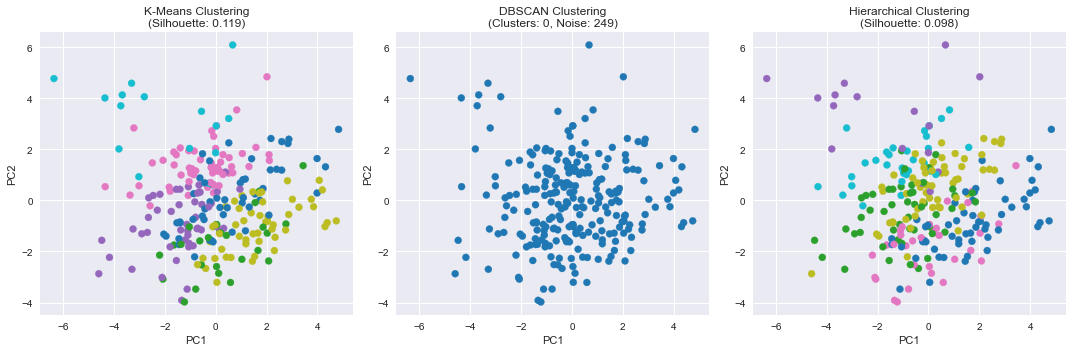

In [72]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10')
plt.title(f'K-Means Clustering\n(Silhouette: {kmeans_silhouette:.3f})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab10')
plt.title(f'DBSCAN Clustering\n(Clusters: {n_clusters_dbscan}, Noise: {n_noise})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='tab10')
plt.title(f'Hierarchical Clustering\n(Silhouette: {hierarchical_silhouette:.3f})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

<h5>6.4 Hyperparameter Optimization 

<h7> Grid Search for SVM

In [74]:
print("\n--- SVM with Grid Search ---")
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']
}

svm_grid_search = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train_scaled, y_train)

print(f"Best SVM parameters: {svm_grid_search.best_params_}")
print(f"Best SVM score: {svm_grid_search.best_score_:.3f}")

# Test best SVM
best_svm = svm_grid_search.best_estimator_
best_svm_pred = best_svm.predict(X_test_scaled)
print("Optimized SVM Classification Report:")
print(classification_report(y_test, best_svm_pred))


--- SVM with Grid Search ---
Best SVM parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM score: 0.759
Optimized SVM Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        23
           1       0.68      0.65      0.67        20
           2       0.50      0.33      0.40         3
           4       0.14      0.50      0.22         2
           5       1.00      0.50      0.67         2

    accuracy                           0.64        50
   macro avg       0.62      0.54      0.54        50
weighted avg       0.70      0.64      0.66        50



<h7>Randomized Search for Random Forest  

In [75]:
print("\n--- Random Forest with Randomized Search ---")
param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001],
    'max_iter': [300, 500],
    'random_state': [42]
}

rf_random_search = GridSearchCV(MLPClassifier(), param_grid_mlp, 
                                    cv=5, scoring='balanced_accuracy')
rf_random_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {rf_random_search.best_params_}")
print(f"Best score: {rf_random_search.best_score_:.3f}")

# Test best Random Forest
best_rf = rf_random_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)
print("Optimized Classification Report:")
print(classification_report(y_test, best_rf_pred))


--- Random Forest with Randomized Search ---


KeyboardInterrupt: 

<h3>7. Models comparison

In [76]:
print("\n=== MODEL COMPARISON ===")

models = {
    'SVM': (svm_clf, svm_pred),
    'KNN': (knn_clf, knn_pred),
    'Logistic Regression' : (lr_clf, lr_pred),
    'Linear Discriminant Analysis': (lda_clf, lda_pred),
    'Naive Bayes': (nb_clf, nb_pred),
    'MLP Classifier': (mlp_clf, mlp_pred),
    'Ridge Classifier': (ridge_clf, ridge_pred),
    'Random Forest': (rf_clf, rf_pred),
    'XGBoost' : (xgb_clf, xgb_pred),
    'CatBoost': (cat_clf, cat_pred),
    'Voting Classifier': (voting_clf, voting_pred),
    'Stacking Classifier': (stacking_clf, stacking_pred),
    'SVM (Optimized)': (best_svm, best_svm_pred)
}

print("Model Accuracy Comparison: (full reduced feature set)")
print("-" * 40)
for name, (model, pred) in models.items():
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    balanced_accuracy = balanced_accuracy_score(y_test, pred)
    print(f"{name:30s}: Accuracy: {accuracy:.3f}, F1: {f1:.3f}, Recall: {recall:.3f}, Balanced Acc: {balanced_accuracy:.3f}")


=== MODEL COMPARISON ===
Model Accuracy Comparison: (full reduced feature set)
----------------------------------------
SVM                           : Accuracy: 0.640, F1: 0.672, Recall: 0.640, Balanced Acc: 0.776
KNN                           : Accuracy: 0.680, F1: 0.643, Recall: 0.680, Balanced Acc: 0.315
Logistic Regression           : Accuracy: 0.580, F1: 0.588, Recall: 0.580, Balanced Acc: 0.360
Linear Discriminant Analysis  : Accuracy: 0.700, F1: 0.663, Recall: 0.700, Balanced Acc: 0.417
Naive Bayes                   : Accuracy: 0.640, F1: 0.630, Recall: 0.640, Balanced Acc: 0.450
MLP Classifier                : Accuracy: 0.640, F1: 0.605, Recall: 0.640, Balanced Acc: 0.298
Ridge Classifier              : Accuracy: 0.520, F1: 0.568, Recall: 0.520, Balanced Acc: 0.516
Random Forest                 : Accuracy: 0.700, F1: 0.648, Recall: 0.700, Balanced Acc: 0.325
XGBoost                       : Accuracy: 0.680, F1: 0.636, Recall: 0.680, Balanced Acc: 0.317
CatBoost                

<h3>8. Prepare for test data processing

In [37]:
print("\n=== PREPARING FOR TEST DATA ===")

# Select best model based on performance
best_model_name = max(models.keys(), key=lambda k: balanced_accuracy_score(y_test, models[k][1]))
best_model = models[best_model_name][0]

print(f"Selected best model: {best_model_name}")
print(f"Best model accuracy: {balanced_accuracy_score(y_test, models[best_model_name][1]):.3f}")


=== PREPARING FOR TEST DATA ===
Selected best model: SVM
Best model accuracy: 0.756


<h5>8.1 Function to process test images (251 - 347)

In [ ]:
def process_test_images():
    """Process test images and generate predictions"""
    test_results = []
    
    # Assuming test images are numbered 251-347
    for img_id in range(251, 348):
        img_path = os.path.join(test_image_dir, f"{img_id}.JPG")
        mask_path = os.path.join(test_mask_dir, f"binary_{img_id}.tif")
        
        if os.path.exists(img_path) and os.path.exists(mask_path):
            # Extract features
            features = extract_comprehensive_features(img_path, mask_path, img_id)
            if features is not None:
                # Remove non-feature columns
                feature_vector = [features.get(col, 0) for col in feature_cols]
                
                # Scale features using the same scaler
                if best_model_name in ['SVM', 'SVM (Optimized)', 'KNN']:
                    feature_vector_scaled = scaler_ml.transform([feature_vector])
                    prediction = best_model.predict(feature_vector_scaled)[0]
                else:
                    prediction = best_model.predict([feature_vector])[0]
                
                test_results.append({'ID': img_id, 'bug type': prediction})
    
    return test_results

<h5>8.2 Save preprocessing objects for use with test data

In [ ]:
import pickle

preprocessing_objects = {
    'scaler': scaler_ml,
    'feature_columns': feature_cols,
    'best_model': best_model,
    'best_model_name': best_model_name
}

with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print("Preprocessing objects saved for test data processing")

<h3> Summary

In [ ]:
print("\n=== PROJECT SUMMARY ===")
print(f"✓ Feature extraction completed: {len(feature_cols)} features")
print(f"✓ Data visualization: Distributions, PCA, t-SNE, {'UMAP' if has_umap else 'Isomap'}")
print(f"✓ Supervised methods: SVM, KNN")
print(f"✓ Ensemble method: Random Forest")
print(f"✓ Clustering methods: K-Means, DBSCAN, Hierarchical")
print(f"✓ Hyperparameter optimization: Grid Search (SVM), Randomized Search (RF)")
print(f"✓ Best model selected: {best_model_name}")